In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import cesium # great library for creating time series features
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
print(cesium.__version__)
print(xgb.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.9.12
1.2.1
1.5.4
0.23.2


## Load data and generate some features of interest

In [4]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [5]:
type(eeg)

dict

In [7]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

### Visually inspect

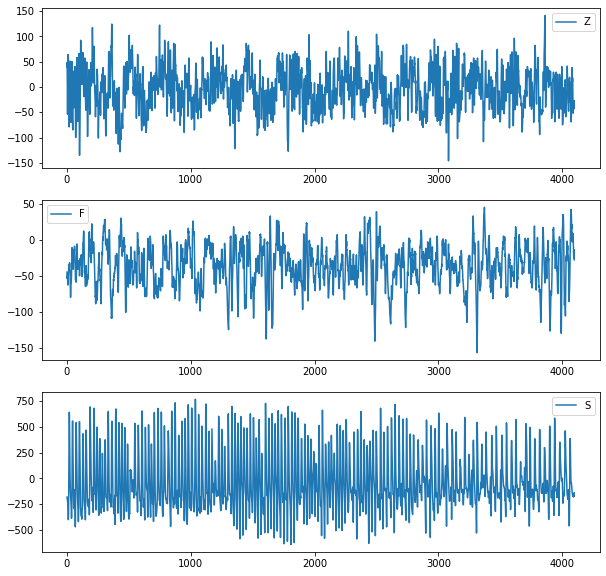

In [8]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [9]:
type(eeg["measurements"][0])

numpy.ndarray

In [10]:
type(eeg)

dict

In [11]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [12]:
type(eeg['measurements'])

list

In [13]:
len(eeg['measurements'])

500

In [14]:
eeg['measurements'][0].shape

(4097,)

## Generate the features

In [ ]:
# This is the code she used to create the features.  She stored them in full_eeg_data_features.csv
# from cesium import featurize as ft
# features_to_use = ["amplitude",
#                    "percent_beyond_1_std",
#                    "percent_close_to_median",
#                   "skew",
#                   "max_slope"]
# fset_cesium = ft.featurize_time_series(times=eeg["times"],
#                                               values=eeg["measurements"],
#                                               errors=None,
#                                               features_to_use=features_to_use,
#                                              scheduler = None)

In [6]:
fset_cesium = pd.read_csv("data/full_eeg_data_features.csv", header = [0, 1])

In [7]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [ ]:
# fset_cesium.to_csv("full_eeg_data_features.csv")

In [8]:
fset_cesium.shape

(500, 6)

## Exercise: validate/calculate these features by hand
#### look up feature definitions here: http://cesium-ml.org/docs/feature_table.html
confirm the values by hand coding these features for the first EEG measurement
(that is eeg["measurements"][0])

In [9]:
ex = eeg["measurements"][0]

In [10]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [11]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [12]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [13]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <BarContainer object of 10 artists>)

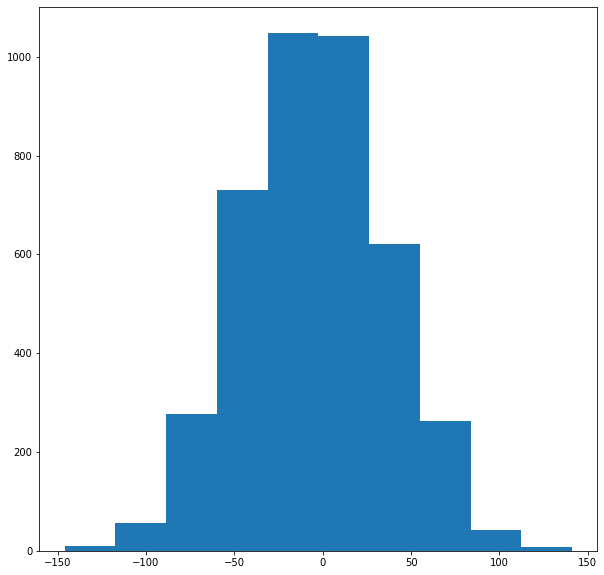

In [14]:
## skew
print(skew(ex))
plt.hist(ex)

In [15]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <BarContainer object of 10 artists>)

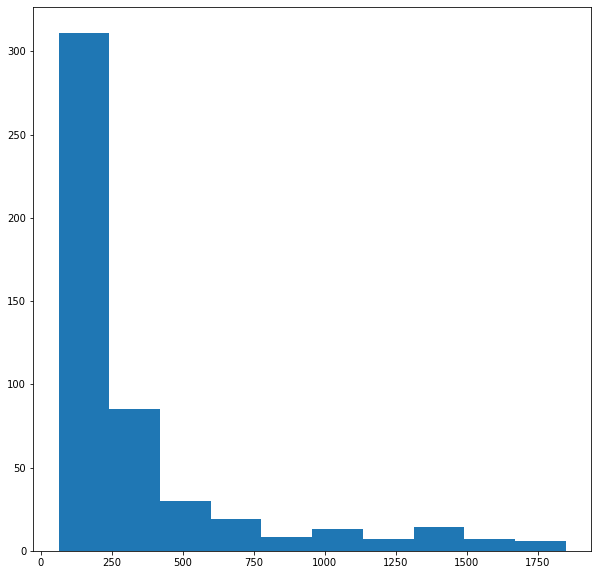

In [16]:
plt.hist(fset_cesium.iloc[:, 1])

In [17]:
fset_cesium['classes'] = eeg['classes']

In [18]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: amplitude, dtype: object

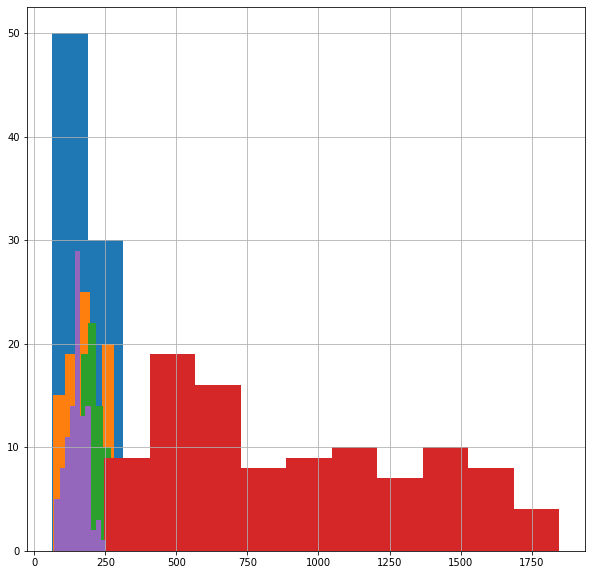

In [19]:
fset_cesium.groupby('classes')['amplitude'].hist() #Great test to gain evidence that amplitude will be a distinguishing feature

array([[<AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'N'}>],
       [<AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'S'}>],
       [<AxesSubplot:title={'center':'Z'}>, <AxesSubplot:>]], dtype=object)

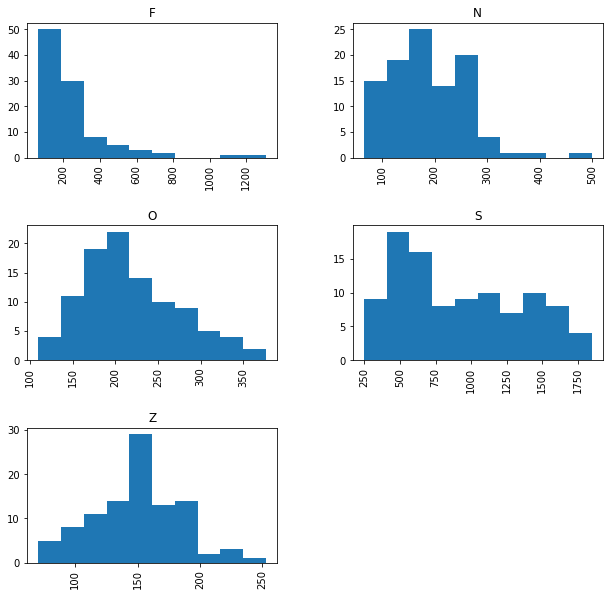

In [20]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'N'}>],
       [<AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'S'}>],
       [<AxesSubplot:title={'center':'Z'}>, <AxesSubplot:>]], dtype=object)

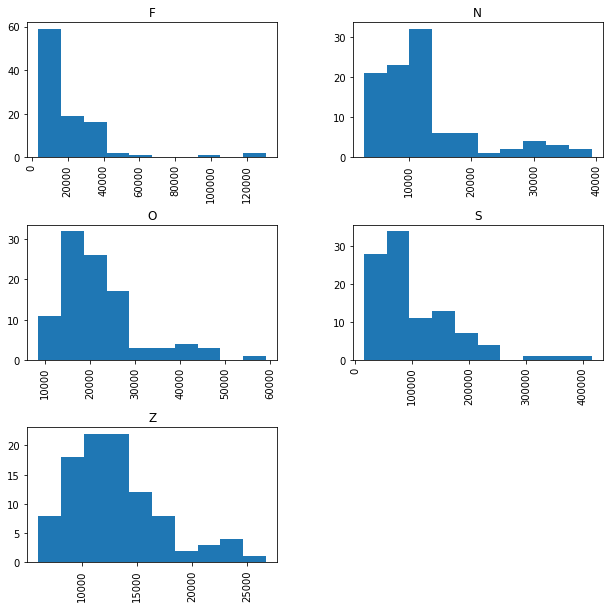

In [21]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

## Prepare data for training

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

## Try a random forest with these features

In [23]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [24]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [25]:
clf.score(X_train, y_train)

0.6266666666666667

In [26]:
clf.score(X_test, y_test)

0.616

In [27]:
np.unique(y_test, return_counts=True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'), array([20, 29, 21, 25, 30]))

In [28]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N'], dtype='<U1')

In [29]:
y_test.shape

(125,)

In [30]:
y_train.shape

(375,)

## Try XGBoost with these features

In [31]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
model.score(X_test, y_test)

0.688

In [33]:
model.score(X_train, y_train)

0.7866666666666666

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

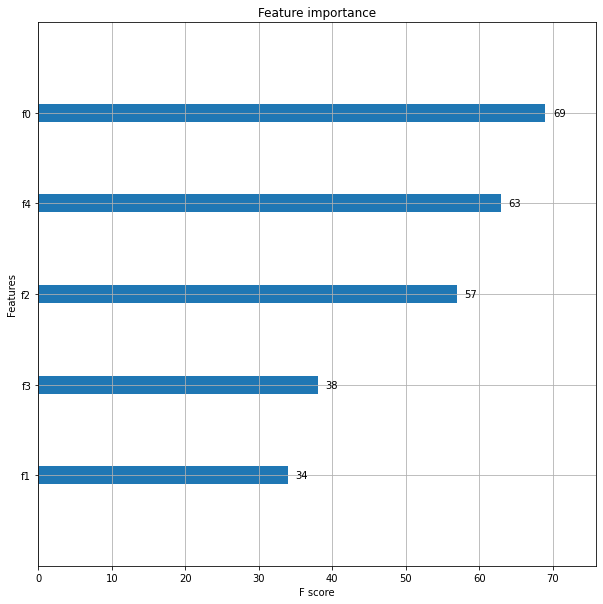

In [34]:
xgb.plot_importance(model)

## Time Series Forecasting with Decision Trees

In [35]:
ap = pd.read_csv("data/AirPassengers.csv", parse_dates=[0])

In [36]:
ap.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [37]:
ap.set_index('Month', inplace=True)

In [38]:
ap.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


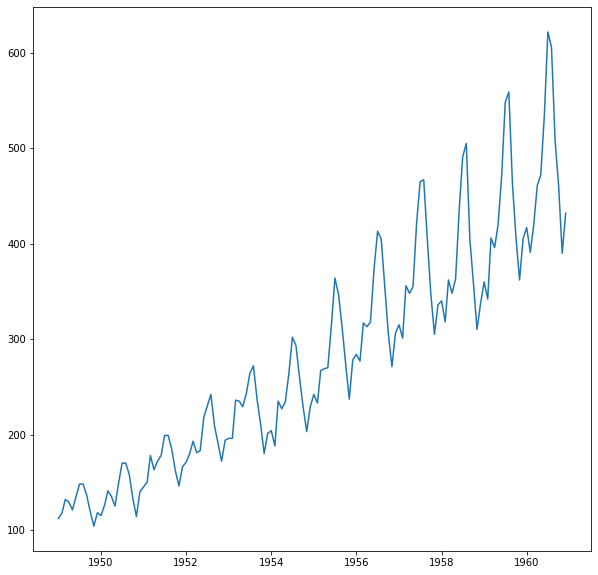

In [39]:
plt.plot(ap)

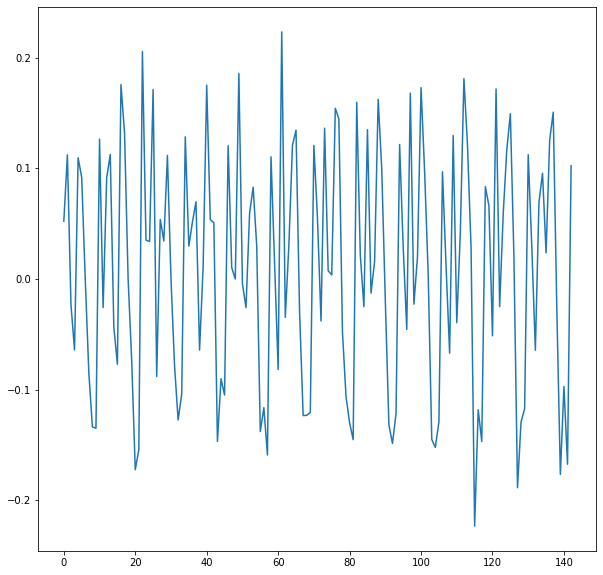

In [40]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [41]:
ts = np.diff(np.log(ap.values[:, 0]))

## Exercise: now that we have 1 time series, how can we convert it to many samples?

In [42]:
NSTEPS = 12

In [43]:
ts.shape

(143,)

In [44]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [45]:
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [46]:
vals.shape

(143, 12)

In [47]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [48]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [49]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [50]:
vals.shape

(132, 12)

In [51]:
vals[-1]

array([ 0.02919916, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067334, -0.02606011, -0.17639855, -0.0970834 ,
       -0.1672513 ,  0.10227885], dtype=float32)

In [52]:
ts[-NSTEPS:]

array([ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
       -0.1672513 ,  0.10227885])

In [53]:
vals.shape

(132, 12)

## Exercise: now that we have the time series broken down into a set of samples, how to featurize?

In [54]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [55]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [56]:
measures[0]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629372], dtype=float32)

In [57]:
len(measures[0])

11

In [58]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

In [59]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [60]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <BarContainer object of 10 artists>)

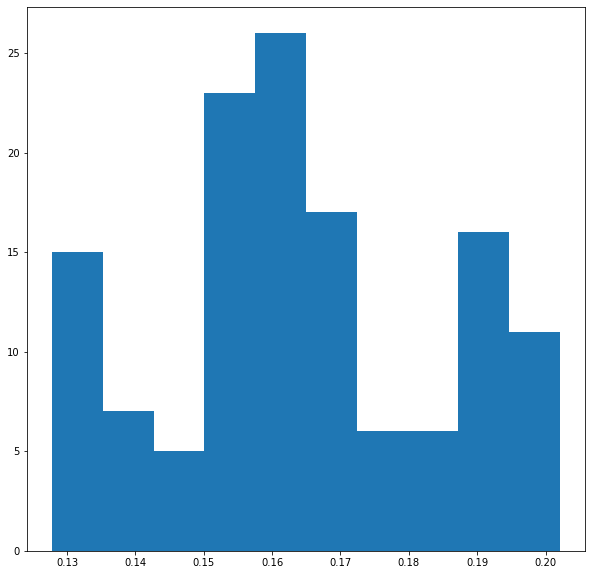

In [61]:
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <BarContainer object of 10 artists>)

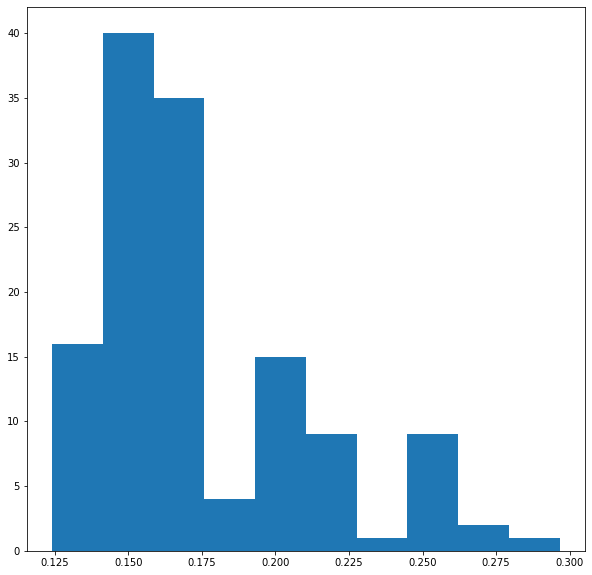

In [62]:
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <BarContainer object of 10 artists>)

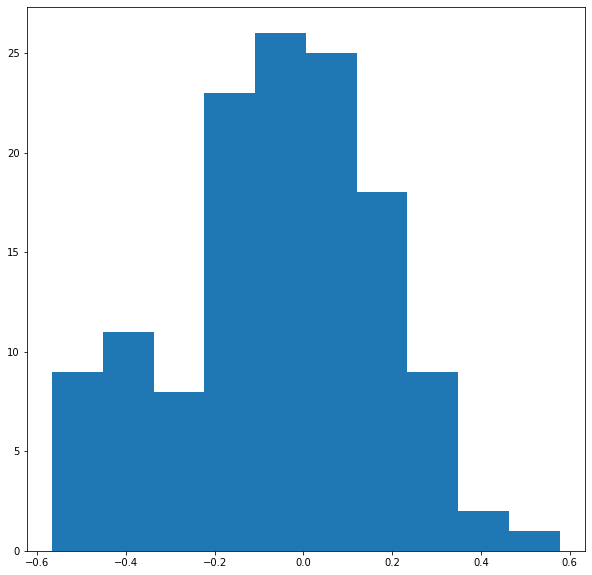

In [63]:
plt.hist(fset_ap['skew'])

## Exercise: can you fit an XGBRegressor to this problem? Let's use the first 100 'time series' as the training data

In [64]:
outcomes = vals[:, -1]

In [65]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [66]:
X_train.shape

(100, 5)

In [67]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [68]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.35238
[1]	validation_0-rmse:0.24899
[2]	validation_0-rmse:0.18153
[3]	validation_0-rmse:0.13436
[4]	validation_0-rmse:0.11567
[5]	validation_0-rmse:0.11137
[6]	validation_0-rmse:0.11651
[7]	validation_0-rmse:0.12062
[8]	validation_0-rmse:0.12236
[9]	validation_0-rmse:0.12612
[10]	validation_0-rmse:0.13090
[11]	validation_0-rmse:0.14120
[12]	validation_0-rmse:0.14200
[13]	validation_0-rmse:0.14292
[14]	validation_0-rmse:0.14840
[15]	validation_0-rmse:0.15697
[16]	validation_0-rmse:0.15734
[17]	validation_0-rmse:0.15793
[18]	validation_0-rmse:0.15884
[19]	validation_0-rmse:0.15802


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### RMSE can be hard to digest .... How does the model perform?

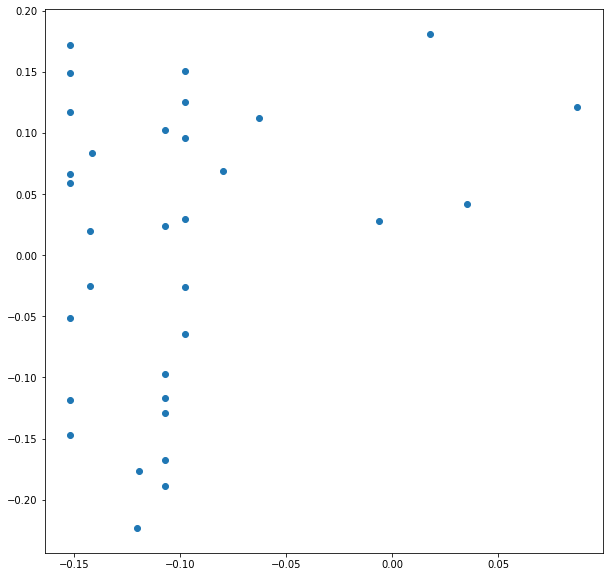

In [69]:
plt.scatter(model.predict(X_test), y_test)

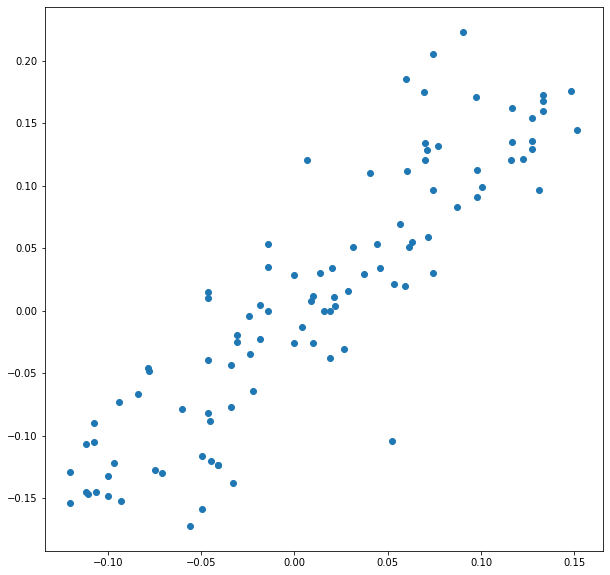

In [70]:
plt.scatter(model.predict(X_train), y_train)

In [71]:
pearsonr(model.predict(X_train), y_train)

(0.8894944136146448, 4.185039316072726e-35)

In [72]:
pearsonr(model.predict(X_test), y_test)

(0.256645932973834, 0.15621264757413464)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

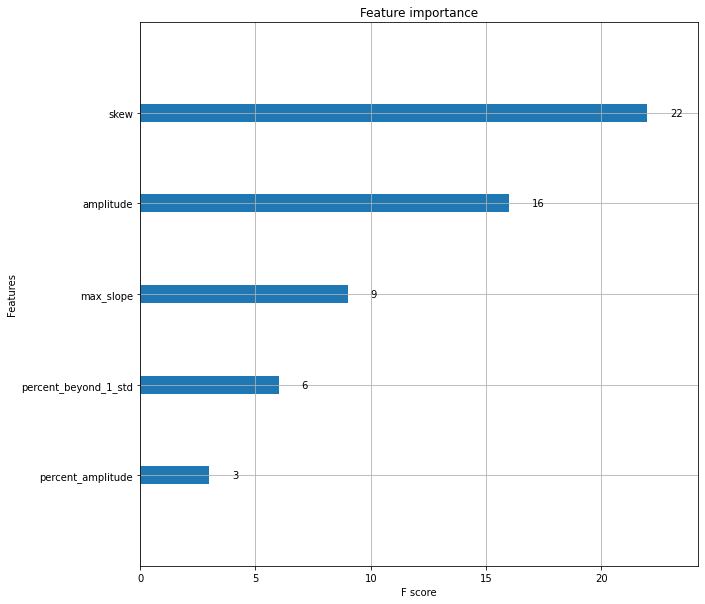

In [73]:
xgb.plot_importance(model)

### What went wrong? Let's revisit the feature set

In [ ]:
fset_ap.head()

In [ ]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])

## We need to find a way to generate features that encode positional information

### now we will generate our own features

In [ ]:
vals.shape

In [ ]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [ ]:
feats[0:3]

### How do these look compared to the first set of features?

In [ ]:
pd.DataFrame(feats[0:3])

In [ ]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [ ]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

In [ ]:
plt.scatter(model.predict(X_test), y_test)

In [ ]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

In [ ]:
plt.scatter(model.predict(X_train), y_train)

In [ ]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))